In [1]:
import os
notebook_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np

os.chdir(os.path.join(notebook_wd, '..'))
from src.d00_utils.conf_utils import *
from src.d00_utils.processing_utils import perform_bootstrap

In [3]:
compounds, water = load_compounds()
experiments = load_experiments()
constants = load_constants()
paths = load_paths()
experiments['bd_dry']

{'composition': {'Butenedial': 0.075, 'PEG-6': 0.2},
 'solution_name': 'bd10hg20_008',
 'idx_range': [63, 500],
 'bad_idx': [113],
 'trap_time': [2, 50],
 'other_query': 'rh<20',
 'y_col': 'mz85/mz283',
 'p283_cutoff': 1000,
 'columns_to_keep': ['trapped', 'comp', 'experiment', 'mz85/mz283'],
 'number_of_steps': 3000.0,
 'r_init': [1.14e-05, 1.44e-05],
 'T': [298.6, 301.6],
 'RH': [0.0, 0.05],
 'x_water': [0.0, 0.05],
 'value_idx': 0,
 'norm_idx': 1,
 'cal_data_time': 5,
 'label': 'BD (dry)'}

In [4]:
def convert_mass_to_molar_composition(mass_composition, compounds):

    molar_composition = {}
    for component, mass_fraction in mass_composition.items():
        for name, compound in compounds.items():
            if compound['name'] == component:
                mole_fraction = mass_fraction / compound['mw']
                molar_composition.update({component: mole_fraction})

    return molar_composition

In [5]:
molar_composition = convert_mass_to_molar_composition(experiments['bd_dry']['composition'], compounds)
print(molar_composition)

{'Butenedial': 0.6244796003330557, 'PEG-6': 0.7084661707403472}


In [6]:
from src.d00_utils.data_utils import import_ms_data
from src.d01_data.process_ms_data import *

In [7]:
df = import_ms_data(file_name=paths['raw_data'])
df.head()

,date,file,chrom,dc_trap,mfc,src1,src2,signal,vialstart,trapstart,...,p84_j,p85_j,p283_j,n84_j,n84,n85_j,n85,bad_data,nh3_vial,naoh_vial
0,180815,6,0.52,680.0,303.0,NaN,NaN,1,NaN,NaN,...,NaN,3470.9,58881.1,NaN,0.000705,0.058948,0.058387,NaN,NaN,NaN
1,180815,6,8.66,600.0,244.0,NaN,NaN,1,NaN,NaN,...,NaN,1370.8,21289.4,NaN,0.001825,0.064389,0.060608,NaN,NaN,NaN
2,180816,1,0.85,470.0,250.0,NaN,NaN,1,NaN,NaN,...,NaN,1738.1,55019.3,NaN,0.000779,0.031591,0.032168,NaN,NaN,NaN
3,180816,2,1.00,570.0,275.0,NaN,NaN,1,NaN,NaN,...,NaN,2199.8,98592.0,NaN,0.000090,0.022312,0.022524,NaN,NaN,NaN
4,180816,3,1.00,560.0,245.0,NaN,NaN,1,NaN,NaN,...,NaN,477.2,20871.9,NaN,0.002030,0.022863,0.021951,NaN,NaN,NaN


In [8]:
df_filtered = filter_ms_data_in_experiments(df, experiments)
df_cleaned = clean_ms_data_in_experiments(df_filtered, experiments)
df_cleaned.columns

Index(['mins', 'solution_name', 'experiment', 'mz85/mz283'], dtype='object')

In [9]:
def extract_calibration_data(df, t_init_cutoff, cal_data_col):
    """"""

    calibration_data_query = "mins<={}".format(t_init_cutoff)
    ms_signal_inits = df.query(calibration_data_query)[cal_data_col].values

    return ms_signal_inits

In [10]:
dfcal = extract_calibration_data(df_cleaned, 5, 'mz85/mz283')
dfcal

array([0.04950509, 0.03339879, 0.02404221, 0.02281234, 0.0249745 ,
       0.03512101, 0.02975492, 0.03036752, 0.02709785, 0.02357413,
       0.03711957, 0.11233162, 0.04560863, 0.07187716, 0.09937988,
       0.1017902 , 0.09797737, 0.05993994, 0.0893675 , 0.0948873 ,
       0.05861352, 0.07927909, 0.29070792, 0.49927666])

In [43]:
def get_bootstrapped_statistics(data):
    """"""
    
    samples = perform_bootstrap(data)
    sample_means = np.mean(samples, axis=0)
    sample_avg = np.mean(sample_means)
    sample_std = np.std(sample_means)
    
    sample_rel_std = sample_std / sample_avg
    
    return sample_avg, sample_rel_std

In [44]:
s_avg, s_rstd = get_bootstrapped_statistics(dfcal)
s_rstd

0.01231315099501568

In [46]:
def calibrate_ms_data(df, experiments, analyte='Butenedial', internal_standard='PEG-6'):
    """"""
    
    df_calibrated = pd.DataFrame()
    for experiment_name, experiment_defs in experiments.items():
        
        df_experiment = df[df.experiment == experiment_name]
        ms_signal_inits = extract_calibration_data(df=df_experiment, 
                                                   t_init_cutoff=experiment_defs['cal_data_time'], 
                                                   cal_data_col=experiment_defs['y_col'])
        ms_signal_inits_avg, ms_signal_inits_rel_std = get_bootstrapped_statistics(ms_signal_inits)

        for compound_name, compound_mol_frac in experiment_defs['composition'].items():
            internal_standard_mol_frac = experiment_defs['composition'][internal_standard]
            
            if compound_name == analyte:
                rel_molar_abundance_in_solution = compound_mol_frac / internal_standard_mol_frac
                cal_factor_avg = ms_signal_inits_avg / rel_molar_abundance_in_solution
                cal_factor_std = ms_signal_inits_rel_std

                col_name = experiment_defs['y_col'].replace('mz', 'mol')

                df_experiment[col_name] = df_experiment[experiment_defs['y_col']] / cal_factor_avg
                df_experiment[col_name + '_std'] = df_experiment[col_name] * cal_factor_std
    
        df_calibrated = df_calibrated.append(df_experiment)
        
    return df_calibrated

In [47]:
df_calibrated = calibrate_ms_data(df_cleaned, experiments, analyte='Butenedial', internal_standard='PEG-6')
df_calibrated.head()

C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dropletenv\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dropletenv\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mins,solution_name,experiment,mz85/mz283,mol85/mol283,mol85/mol283_std
102,23.0,bd10hg20_008,bd_dry,0.009295,0.107374,0.000314
103,22.0,bd10hg20_008,bd_dry,0.014990,0.173153,0.000506
104,21.0,bd10hg20_008,bd_dry,0.005597,0.064657,0.000189
105,46.0,bd10hg20_008,bd_dry,0.013988,0.161578,0.000472
107,10.0,bd10hg20_008,bd_dry,0.027411,0.316630,0.000925


In [48]:
from src.d05_reporting.plot_ms_data import plot_ms_data

df_calibrated = add_calibrated_ms_data_column(df_cleaned, experiments, analyte='Butenedial', internal_standard='PEG-6')
df_calibrated.head()

,mins,solution_name,experiment,mz85/mz283,mol85/mol283,mol85/mol283_std,mol85/mol85_0
102,23.0,bd10hg20_008,bd_dry,0.009295,0.107387,0.000021,0.286365
103,22.0,bd10hg20_008,bd_dry,0.014990,0.173175,0.000034,0.461799
104,21.0,bd10hg20_008,bd_dry,0.005597,0.064665,0.000013,0.172441
105,46.0,bd10hg20_008,bd_dry,0.013988,0.161599,0.000031,0.430929
107,10.0,bd10hg20_008,bd_dry,0.027411,0.316670,0.000061,0.844452


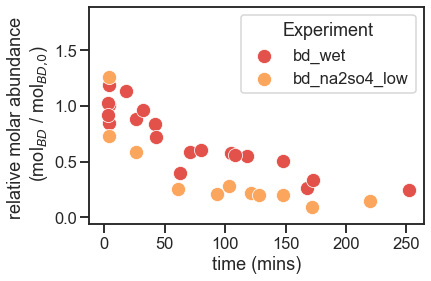

In [49]:
plot_ms_data(df_calibrated, ['bd_wet', 'bd_na2so4_low'], 'mins', y_col_name='mol85/mol85_0', analyte='BD', internal_standard='PEG6')